In [1]:
import sys
import sklearn
import mne

from nilearn import image
import numpy as np
import matplotlib.pyplot as plt

#my codes 
from fMRI_Regions import get_masked_fmri
from  original_input import create_dataset
import make_input
import methods

### Download and preprocess data

In [2]:
eeg_path = '../data/eeg_fmri_data_trio_four_subjects/eeg_on/eeg_on_1.edf'
fmri_path = '../data/eeg_fmri_data_trio_four_subjects/fmri_on/fmri_on_1.nii'

args = {'start_time': 0, 
        'end_time': 100000, 
        'delay': 0, 
        'fmri_end': 100000,
        'eeg_path': eeg_path,
        'fmri_path': fmri_path}

In [3]:
dataset_settings = make_input.Dataset(random_seed=42, segment_length=16384, eeg_padded=False,
                                       frame_creation_time=1950, step=195)
data = dataset_settings.create_dataset(**args)

Extracting EDF parameters from d:\Work\HSE_project\EEG_fMRI\data\eeg_fmri_data_trio_four_subjects\eeg_on\eeg_on_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (1.651 sec)

(30, 1)
Size of raw EEG data:  (30, 305000)
Size of FFT of raw EEG data:  (30, 305000)
Size of fMRI data:  (61, 72, 61, 150)


In [4]:
### Data information
x_list, y_list, x_fl_list = data
print('Retrieve FFT: ', x_list.shape, y_list.shape, x_fl_list.shape)

### Reshape data in time-freq
x_list = x_list.reshape(x_list.shape[0], x_list.shape[1], -1 )
x_fl_list = x_fl_list.reshape(x_fl_list.shape[0], x_fl_list.shape[1], -1 )

print('Reshape data:', x_list.shape, y_list.shape, x_fl_list.shape)

### Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2, shuffle=False)
print('Sizes of training data:', X_train.shape, y_train.shape)
print('Sizes of test data: ', X_test.shape, y_test.shape)

Retrieve FFT:  (429, 30, 17, 60) (429, 21) (429, 30, 17, 60)
Reshape data: (429, 30, 1020) (429, 21) (429, 30, 1020)
Sizes of training data: (343, 30, 1020) (343, 21)
Sizes of test data:  (86, 30, 1020) (86, 21)


## Fit model

In [93]:
model = methods.linear_pattern_recognition()
model.fit(X_train, X_test, y_train, y_test)

Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size step b:  (343, 30) (30,)
Size step a:  (343, 1020) (1020,)
Size s

In [94]:
print('Amount of different models: ', len(model.model))

topo_coef_1  = model.topo_coefs_[0]
spect_coef_1  = model.spect_coefs_[0]
print('Topological coef,', topo_coef_1.shape, '\nFreq_time coef: ', spect_coef_1.shape)

Amount of different models:  21
Topological coef, (1, 30) 
Freq_time coef:  (1020, 1)


## Prediction of BOLD signals using estimated coefficient

In [95]:
def make_transformation(sample, topo, freq):
    """
    sample : (30, 1020)
    topo : (1, 30)
    freq: (1020, 1)
    """
    x = np.dot(topo, sample)
    x = np.dot(x, freq)
    return x

### Train data 

In [96]:
y_hat = []
for region in range(21):
    y_hat_1  = make_transformation(X_train, model.topo_coefs_[region], model.spect_coefs_[region])
    y_hat_1 = y_hat_1.squeeze()
    y_hat.append(y_hat_1)
    
y_hat = np.array(y_hat).T
print('Size of prediction', y_hat.shape)

Size of prediction (343, 21)


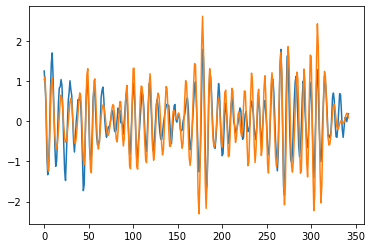

In [97]:
region = 11
plt.plot(y_hat[:, region])
plt.plot(y_train[:, region])
# plt.plot(y_train[:, region] - y_hat[:, region])

### Test data prediction.
- make prediction 
- correlation between prediction and real test data
- plot region with high correllation

In [121]:
### make prediction
y_hat_test = []
for region in range(21):
    y_hat_1  = make_transformation(X_test, model.topo_coefs_[region], model.spect_coefs_[region])
    y_hat_1 = y_hat_1.squeeze()
    y_hat_test.append(y_hat_1)
    
y_hat_test = np.array(y_hat_test).T
print('Size of prediction', y_hat_test.shape)

Size of prediction (86, 21)


In [99]:
### correlation between prediction and real test data
corr = []
for region in range(y_test.shape[-1]):
    corr.append(np.corrcoef(y_test[:, region],y_hat_test[:, region])[0,1])
corr = np.array(corr)
idx = np.argsort(corr)
idx = idx[::-1]
corr[idx]

array([ 0.56881173,  0.43285505,  0.4244066 ,  0.40736936,  0.38754648,
        0.21837176,  0.12614738,  0.09992946,  0.09384141,  0.03807403,
        0.02935144,  0.02158789, -0.01641387, -0.03096644, -0.04656835,
       -0.061175  , -0.08534948, -0.11744565, -0.14188927, -0.18071356,
       -0.2462425 ])

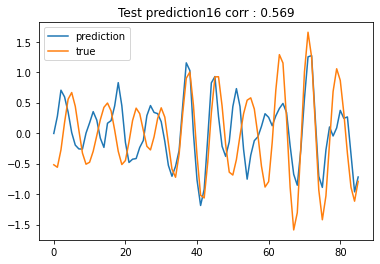

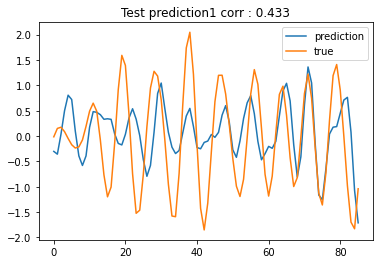

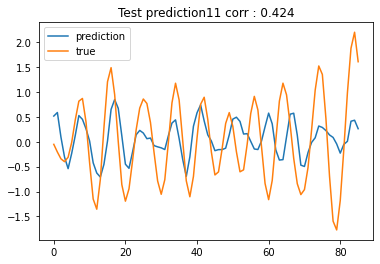

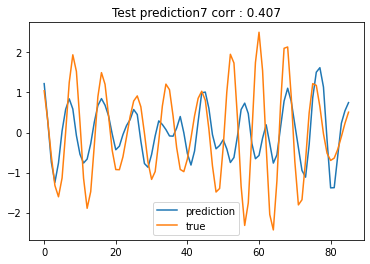

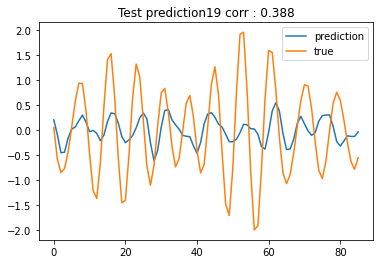

In [100]:
### plot region with high correllation
n_top_corr=5 
for i in range(n_top_corr):
    region = idx[i]
    plt.title('Test prediction' + str(region) + ' corr : '+ str(np.round(corr[region], 3)))
    plt.plot(y_hat_test[:, region], label = 'prediction')
    plt.plot(y_test[:, region], label = 'true')
    # plt.plot(y_train[:, region] - y_hat[:, region])
    plt.legend()
    plt.show()

(array([2.0179e+04, 3.8410e+03, 1.7110e+03, 7.9300e+02, 5.2200e+02,
        3.2300e+02, 6.7600e+02, 5.0400e+02, 3.1800e+02, 3.3400e+02,
        3.2000e+02, 1.8400e+02, 1.4900e+02, 8.2000e+01, 5.3000e+01,
        2.0000e+02, 5.7000e+01, 2.8200e+02, 6.5000e+01, 7.0000e+00]),
 array([1.98076467e-06, 3.84158933e-03, 7.68119789e-03, 1.15208065e-02,
        1.53604150e-02, 1.92000236e-02, 2.30396321e-02, 2.68792407e-02,
        3.07188493e-02, 3.45584578e-02, 3.83980664e-02, 4.22376750e-02,
        4.60772835e-02, 4.99168921e-02, 5.37565007e-02, 5.75961092e-02,
        6.14357178e-02, 6.52753264e-02, 6.91149349e-02, 7.29545435e-02,
        7.67941520e-02]),
 <a list of 20 Patch objects>)

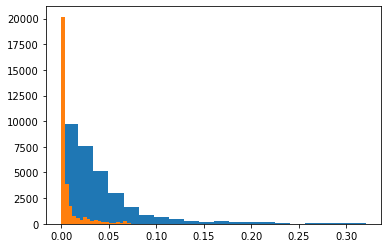

In [120]:
plt.hist(np.mean(X_train[:], axis = 0).flat, bins = 20)
plt.hist(np.var(X_train[:], axis = 0).flat, bins = 20)

## Animation of data
**It is additional **

In [13]:
from IPython.display import HTML
from celluloid import Camera   # it is convinient method to animate

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())

fig, axes = plt.subplots(1)
camera = Camera(fig)
t = np.arange(X_test.shape[0])
for i in t:
    axes.imshow(X_train[i, 21, :].reshape( 17, 60))
    camera.snap()
    
animation = camera.animate()
display_animation(animation)

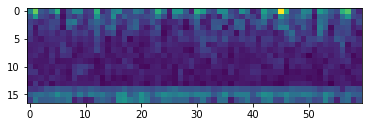

In [15]:
plt.imshow(X_train[100, 0, :].reshape( 17, 60))
# plt.plot(y_train[:, 17])

In [16]:
region = 2
model_region = model.model[region]
y_hat = model_region.predict(X_train[0])

NameError: name 'model1' is not defined

In [17]:
X_train[0].shape, 
model.model[0].predict(X_train)
plt.plot(y_train[:, 1])


ValueError: Found array with dim 3. Estimator expected <= 2.